In [31]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from numpy.linalg import svd
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

data = {
    "unitnames_rotundus": None,
    "responses_fieldl": None,
    "responses_rotundus": None,
    "frequencies": None,
    "itds": None,
    "unitnames_fieldl": None,
}


def get_data_filepath(filename):
    return f"../data/forebrain-data-from-roland/{filename}.npy"


for name in data.keys():
    data[name] = np.load(get_data_filepath(name))
    print("Loaded ", name)

Loaded  unitnames_rotundus
Loaded  responses_fieldl
Loaded  responses_rotundus
Loaded  frequencies
Loaded  itds
Loaded  unitnames_fieldl


In [32]:
print("freqs:\t", data["frequencies"], "\nitds:\t", data["itds"])
print("rotundus data shape:\t", data["responses_rotundus"].shape)
print("field L data shape:\t", data["responses_fieldl"].shape)

freqs:	 [ 1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000. 10000.] 
itds:	 [-240. -150.  -90.  -30.    0.   30.   90.  150.  240.]
rotundus data shape:	 (42, 10, 9)
field L data shape:	 (121, 10, 9)


In [33]:
frequencies = data["frequencies"]
itds = data["itds"]
stim = np.array(list(itertools.product(frequencies, itds)))


def normalize(x):
    return (x - np.mean(x)) / np.std(x)


rt_normalized = np.array(
    [normalize(row) for row in data["responses_rotundus"]]
).reshape((data["responses_rotundus"].shape[0], -1))
assert rt_normalized.shape[-1] == stim.shape[0]
fl_normalized = np.array([normalize(row) for row in data["responses_fieldl"]]).reshape(
    (data["responses_fieldl"].shape[0], -1)
)
assert fl_normalized.shape[-1] == stim.shape[0]

print("Number of neurons: ", rt_normalized.shape[0])
print("Total number of distinct stimuli: ", stim.shape[0])
print("Response array shape (rotundus): ", rt_normalized.shape)
print("Response array shape (fieldl): ", fl_normalized.shape)

Number of neurons:  42
Total number of distinct stimuli:  90
Response array shape (rotundus):  (42, 90)
Response array shape (fieldl):  (121, 90)


In [ ]:
R_rt = rt_normalized.T  # shape (M, N)
R_fl = fl_normalized.T

# PCA via SVD
U_rt, Svals_rt, Vt_rt = svd(R_rt, full_matrices=False)  # R = U S Vt
V_rt = Vt_rt.T
S_rt = np.diag(Svals_rt)
Z_rt = (R_rt @ V_rt)

U_fl, Svals_fl, Vt_fl = svd(R_fl, full_matrices=False)
V_fl = Vt_fl.T
S_fl = np.diag(Svals_fl)
Z_fl = (R_fl @ V_fl)

print("=== Rotundus:")
print(f"Good decomposition?\t{np.linalg.norm(R_rt - U_rt @ S_rt @ Vt_rt)<1e-8}")
print("Transform into PC space, U:\t", U_rt.shape)
print("Transform out of PC space, Vt:\t", Vt_rt.shape)
print("Number of components:", len(Svals_rt))

print("=== Field L:")
print(f"Good decomposition?\t{np.linalg.norm(R_fl - U_fl @ S_fl @ Vt_fl)<1e-8}")
print("Transform into PC space, U:\t", U_fl.shape)
print("Transform out of PC space, Vt:\t", Vt_fl.shape)
print("Number of components:", len(Svals_fl))

=== Rotundus:
Good decomposition?	True
Transform into PC space, U:	 (90, 42)
Transform out of PC space, Vt:	 (42, 42)
Number of components: 42
=== Field L:
Good decomposition?	True
Transform into PC space, U:	 (90, 90)
Transform out of PC space, Vt:	 (90, 121)
Number of components: 90


Rotundus EVR: [0.72042244 0.07999685 0.06553887 0.02746541 0.02099756]
Field L EVR: [0.57514904 0.24005977 0.05113253 0.02423527 0.01779222]


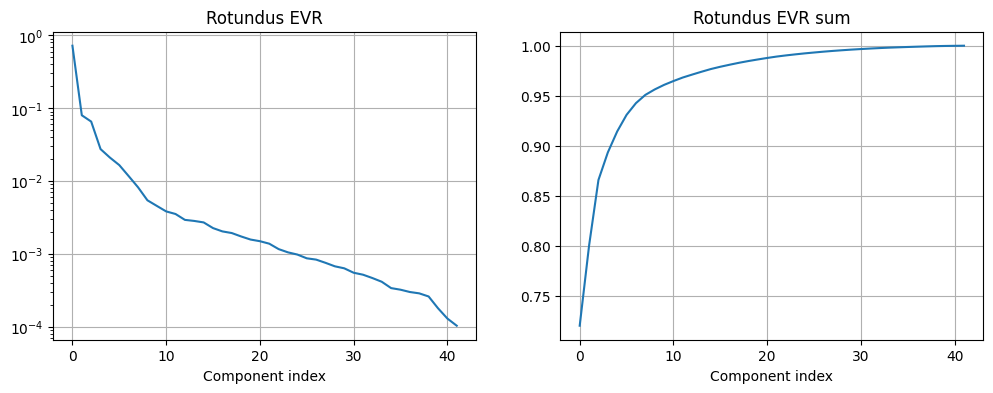

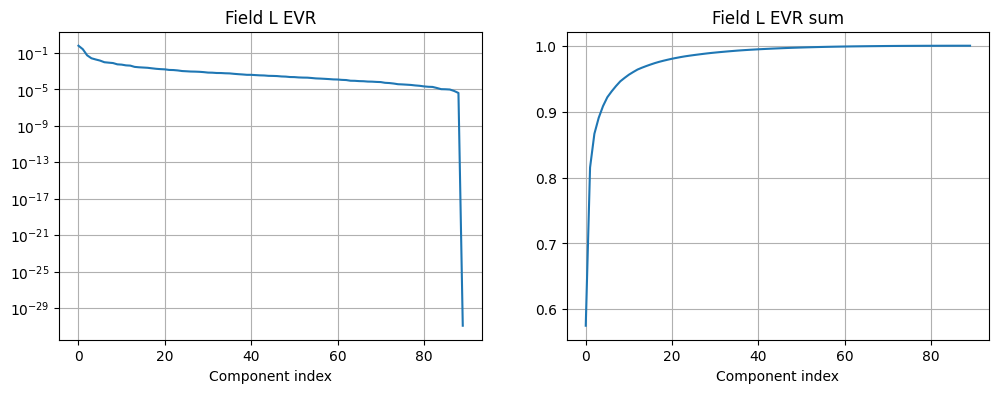

In [79]:
# Explained variance
evals_rt = (Svals_rt**2) / (R_rt.shape[0] - 1)
evr_rt = evals_rt / evals_rt.sum()

print("Rotundus EVR:", evr_rt[:5])

evals_fl = (Svals_fl**2) / (R_fl.shape[0] - 1)
evr_fl = evals_fl / evals_fl.sum()

print("Field L EVR:", evr_fl[:5])

# i would put these on the same figure but they have different numbers of components
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.semilogy(evr_rt)
plt.title("Rotundus EVR")
plt.xlabel("Component index")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(evr_rt.cumsum())
plt.title("Rotundus EVR sum")
plt.xlabel("Component index")
plt.grid()
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.semilogy(evr_fl)
plt.title("Field L EVR")
plt.xlabel("Component index")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(evr_fl.cumsum())
plt.title("Field L EVR sum")
plt.xlabel("Component index")
plt.grid()
plt.show()

(90, 2) (90, 2)


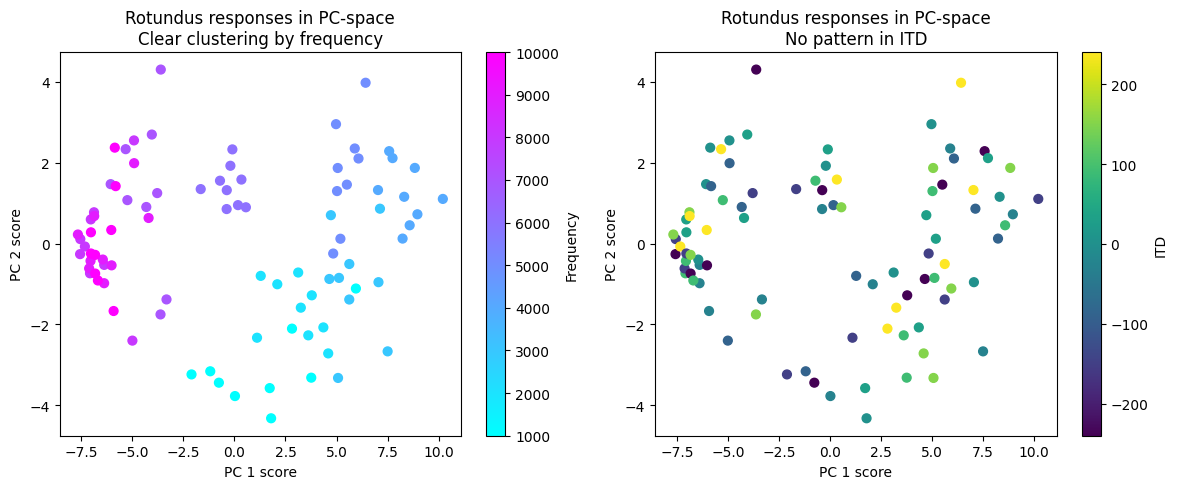

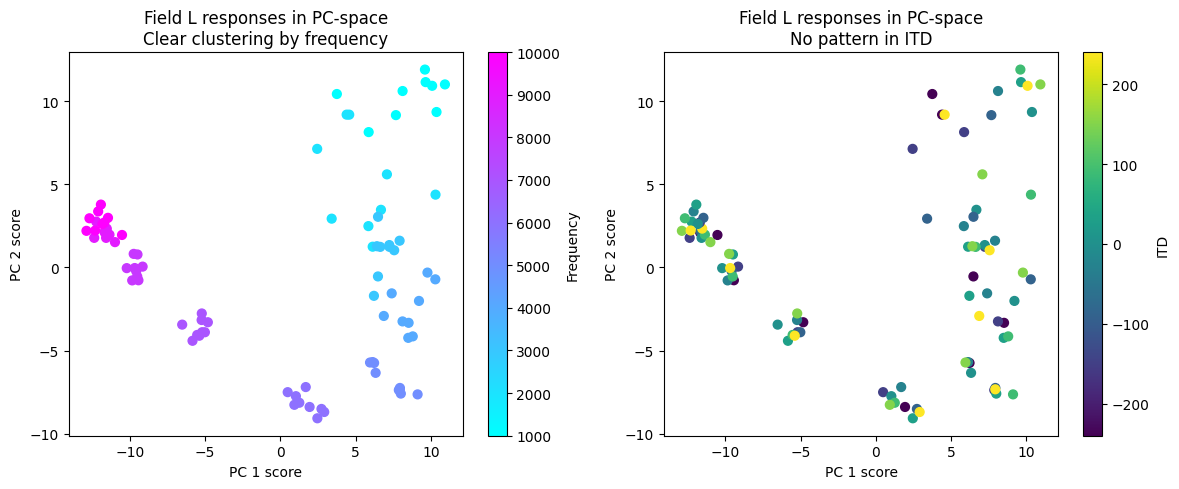

In [81]:
import matplotlib.pyplot as plt

# first two principal component "scores" = original data projected into PC space
Z2_rt = Z_rt[:, :2]  # R @ V
Z2_fl = Z_fl[:, :2]

print(Z2_rt.shape, Z2_fl.shape)

# rotundus
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sc = plt.scatter(Z2_rt[:, 0], Z2_rt[:, 1], c=stim[:, 0], cmap="cool", s=40)  # color by frequency
plt.xlabel("PC 1 score")
plt.ylabel("PC 2 score")
plt.colorbar(sc, label="Frequency")
plt.title("Rotundus responses in PC-space\nClear clustering by frequency")
plt.subplot(1,2,2)
sc = plt.scatter(Z2_rt[:, 0], Z2_rt[:, 1], c=stim[:, 1], cmap="viridis", s=40)  # color by ITD
plt.xlabel("PC 1 score")
plt.ylabel("PC 2 score")
plt.colorbar(sc, label="ITD")
plt.title("Rotundus responses in PC-space\nNo pattern in ITD")
plt.tight_layout()
plt.show()

# field L
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sc = plt.scatter(
    Z2_fl[:, 0], Z2_fl[:, 1], c=stim[:, 0], cmap="cool", s=40
)  # color by frequency
plt.xlabel("PC 1 score")
plt.ylabel("PC 2 score")
plt.colorbar(sc, label="Frequency")
plt.title("Field L responses in PC-space\nClear clustering by frequency")
plt.subplot(1, 2, 2)
sc = plt.scatter(Z2_fl[:, 0], Z2_fl[:, 1], c=stim[:, 1], cmap="viridis", s=40)  # color by ITD
plt.xlabel("PC 1 score")
plt.ylabel("PC 2 score")
plt.colorbar(sc, label="ITD")
plt.title("Field L responses in PC-space\nNo pattern in ITD")
plt.tight_layout()
plt.show()

# Do PCs act as stimulus coordinates?

Compute correlation coefficients between PCs and stimulus values for frequency and ITD separately.

Large correlation coefficients (magnitude closer to 1) suggest that PCs act as stimulus coordinates.

In [76]:
freq = stim[:, 0]
itd = stim[:, 1]

print("=== Rotundus:")
for k in range(5):
    c_f = np.corrcoef(Z_rt[:, k], freq)[0, 1]
    c_i = np.corrcoef(Z_rt[:, k], itd)[0, 1]
    print(f"PC{k+1}: corr(freq)={c_f:.3f}\tcorr(itd)={c_i:.3f}")

print("=== Field L:")
for k in range(5):
    c_f = np.corrcoef(Z_fl[:, k], freq)[0, 1]
    c_i = np.corrcoef(Z_fl[:, k], itd)[0, 1]
    print(f"PC{k+1}: corr(freq)={c_f:.3f}\tcorr(itd)={c_i:.3f}")

=== Rotundus:
PC1: corr(freq)=-0.765	corr(itd)=0.036
PC2: corr(freq)=0.428	corr(itd)=0.035
PC3: corr(freq)=0.177	corr(itd)=-0.100
PC4: corr(freq)=-0.015	corr(itd)=-0.016
PC5: corr(freq)=0.279	corr(itd)=0.021
=== Field L:
PC1: corr(freq)=-0.908	corr(itd)=0.032
PC2: corr(freq)=-0.319	corr(itd)=0.011
PC3: corr(freq)=0.007	corr(itd)=-0.133
PC4: corr(freq)=-0.002	corr(itd)=-0.038
PC5: corr(freq)=0.215	corr(itd)=0.110


In [84]:
# participation ratios
n_keep = 5
pr_rt = np.sum(evals_rt[:n_keep])**2 / np.sum(evals_rt[:n_keep]**2)
pr_fl = np.sum(evals_fl[:n_keep])**2 / np.sum(evals_fl[:n_keep]**2)

print("Participation ratios (rotundus):", pr_rt)
print("Participation ratios (field L):", pr_fl)

Participation ratios (rotundus): 1.575001404353336
Participation ratios (field L): 2.105236617465201
